# Getting familiar with unsupervised learning techniques using Olivetti faces

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces

In [2]:
olivetti = fetch_olivetti_faces(shuffle=True, random_state=42)

olivetti.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

In [3]:
data = olivetti.data
target = olivetti.target

In [4]:
def plot_faces(faces, n_rows=5, n_cols=5, figsize=None):
    size = 64
    
    if len(faces) > n_cols*n_rows:
        idx = np.random.choice(faces.shape[0], n_rows*n_cols, replace=False)
        faces = faces[idx]

    q, r = divmod(len(faces), n_cols)
    n_rows = min(n_rows, q + min(1, r))
    faces = faces.reshape(-1, size, size)
    
    image = np.empty((n_rows*size, n_cols*size), dtype=faces.dtype)
    for i in range(n_rows-1):
        row_image = faces[i*n_cols:(i+1)*n_cols]
        np.concatenate(row_image, axis=1, out=image[size*i:size*(i+1), :])
    row_image = list(faces[(n_rows-1)*n_cols:]) + max(0, n_rows*n_cols - len(faces))*[np.zeros((size, size))]
    np.concatenate(row_image, axis=1, out=image[-size:, :])
    
    if figsize:
        plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

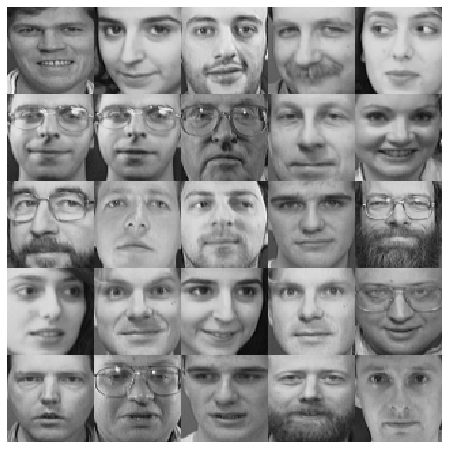

In [5]:
plot_faces(data, figsize=(12, 8))

Since the dataset is quite small, we'll use stratified sampling to make sure the training, validation and the test sets contain photos of all the people.

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

In [7]:
sss = StratifiedShuffleSplit(1, train_size=0.6, random_state=42)

train_index, test_val_index = next(sss.split(data, target))

In [8]:
sss = StratifiedShuffleSplit(1, train_size=0.5, random_state=420)

val_index, test_index = next(sss.split(data[test_val_index], target[test_val_index]))

In [9]:
X_train = data[train_index]
y_train = target[train_index]

X_val = data[val_index]
y_val = target[val_index]

X_test = data[test_index]
y_test = target[test_index]

In [10]:
for photos, name in ((X_train, 'training set'), (X_val, 'validation set'), (X_test, 'test set')):
    print('Shape of the {}: {}'.format(name, photos.shape))

Shape of the training set: (240, 4096)
Shape of the validation set: (80, 4096)
Shape of the test set: (80, 4096)


**The next step we're going to do is to use K-Means to cluster the photos and check whether the algorithm separated groups of photos of different people.**

In [11]:
from sklearn.cluster import KMeans

In [12]:
np.random.seed(4200)

inerties = []
for i in range(5, 105, 5):
    clusterer = KMeans(n_clusters=i, n_init=1)
    clusterer.fit(X_train)
    inerties.append(clusterer.inertia_)
    print('#', end='')

####################

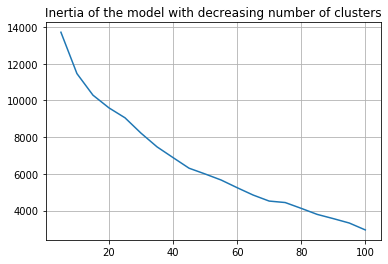

In [13]:
plt.plot(np.arange(5, 105, 5), inerties)
plt.title('Inertia of the model with decreasing number of clusters')
plt.grid(True)

There is no elbow visible on the plot so we need to select the number arbitrarily.

In [14]:
n_clusters = 40
clusterer = KMeans(n_clusters=n_clusters, random_state=42).fit(X_train)

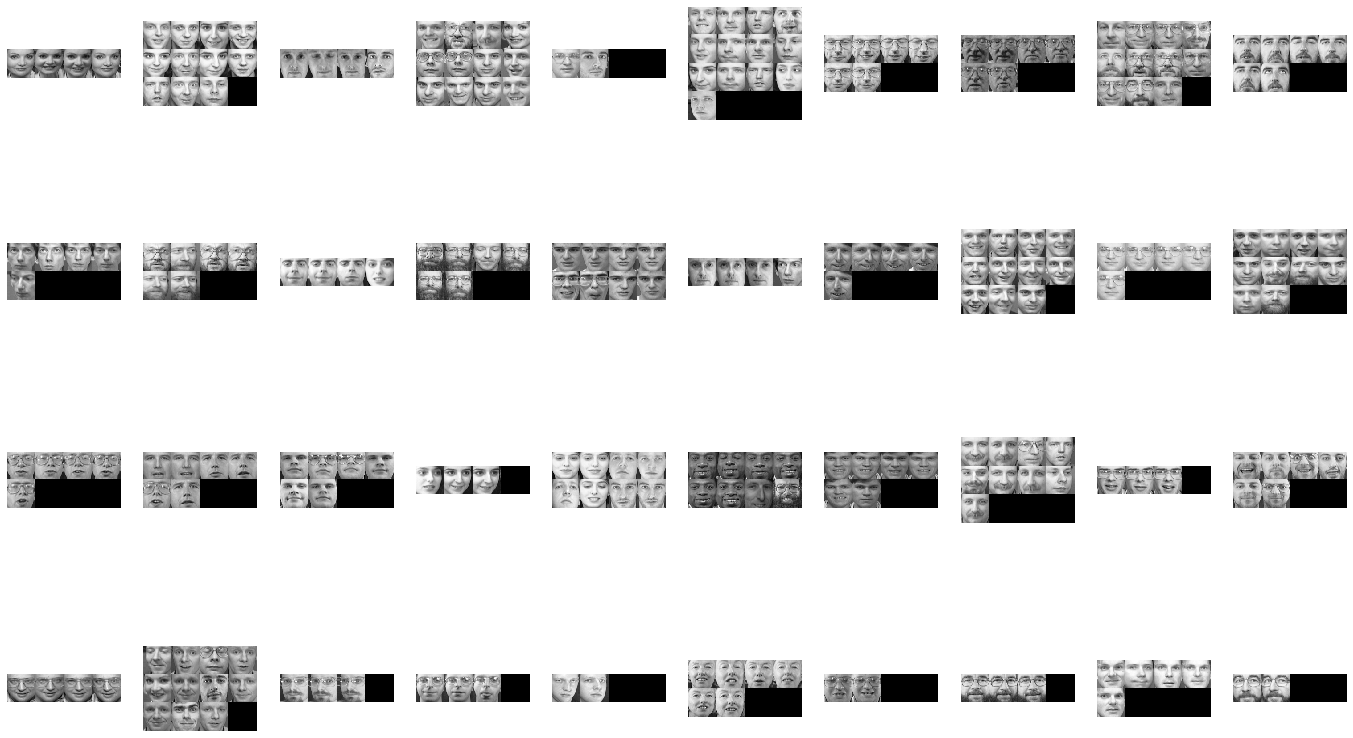

In [15]:
plt.figure(figsize=(24, 30))
for i in range(5):
    for j in range(8):
        cluster = i*8 + j
        plt.subplot(8, 10, cluster+1)
        faces = X_train[clusterer.labels_ == cluster]
        plot_faces(faces, 4, 4)

The clusterer seems to make clusters of similar photos sometimes depicting the same person but in general it fails in making pure groups.

**Now let's try training a classifier on original data and on data prepared using clustering**

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [17]:
rnd_clf = RandomForestClassifier(n_estimators=250, bootstrap=False, random_state=42)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [18]:
accuracy_score(y_val, rnd_clf.predict(X_val), normalize=False), len(X_val)

(79, 80)

Only 1 out of 80 photos of the validation set is misclassified so the model seems reasonably good.

In the next step we'll look for optimal clustering using K-Means and then train the classifier again.

In [19]:
X_train_reduced = clusterer.transform(X_train)
X_val_reduced = clusterer.transform(X_val)
X_test_reduced = clusterer.transform(X_test)

In [20]:
rnd_clf.fit(X_train_reduced, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [21]:
accuracy_score(y_val, rnd_clf.predict(X_val_reduced), normalize=False), len(X_val)

(67, 80)

The model performs poorly, maybe different number of clusters could make it do better.

In [22]:
for n in range(10, 121, 10):
    clusterer = KMeans(n_clusters=n, n_init=5)
    X_train_reduced = clusterer.fit_transform(X_train)
    X_val_reduced = clusterer.transform(X_val)
    rnd_clf.fit(X_train_reduced, y_train)
    y_pred = rnd_clf.predict(X_val_reduced)
    print('Number of clusters: {}, accuracy: {} out of {}'.format(n, accuracy_score(y_val, rnd_clf.predict(X_val_reduced), normalize=False), len(X_val)))

Number of clusters: 10, accuracy: 69 out of 80
Number of clusters: 20, accuracy: 67 out of 80
Number of clusters: 30, accuracy: 66 out of 80
Number of clusters: 40, accuracy: 66 out of 80
Number of clusters: 50, accuracy: 68 out of 80
Number of clusters: 60, accuracy: 73 out of 80
Number of clusters: 70, accuracy: 69 out of 80
Number of clusters: 80, accuracy: 73 out of 80
Number of clusters: 90, accuracy: 68 out of 80
Number of clusters: 100, accuracy: 71 out of 80
Number of clusters: 110, accuracy: 71 out of 80
Number of clusters: 120, accuracy: 70 out of 80


Using K-Means as preprocessing tool in this case doesn't improve the random forest classifier.

Maybe appending the result to the original features will work.

In [23]:
for n in range(10, 121, 10):
    clusterer = KMeans(n_clusters=n, n_init=5)
    X_train_reduced = np.concatenate((X_train, clusterer.fit_transform(X_train)), axis=1)
    X_val_reduced = np.concatenate((X_val, clusterer.transform(X_val)), axis=1)
    rnd_clf.fit(X_train_reduced, y_train)
    y_pred = rnd_clf.predict(X_val_reduced)
    print('Number of clusters: {}, accuracy: {} out of {}'.format(n, accuracy_score(y_val, rnd_clf.predict(X_val_reduced), normalize=False), len(X_val)))

Number of clusters: 10, accuracy: 80 out of 80
Number of clusters: 20, accuracy: 78 out of 80
Number of clusters: 30, accuracy: 79 out of 80
Number of clusters: 40, accuracy: 79 out of 80
Number of clusters: 50, accuracy: 79 out of 80
Number of clusters: 60, accuracy: 80 out of 80
Number of clusters: 70, accuracy: 79 out of 80
Number of clusters: 80, accuracy: 80 out of 80
Number of clusters: 90, accuracy: 80 out of 80
Number of clusters: 100, accuracy: 79 out of 80
Number of clusters: 110, accuracy: 79 out of 80
Number of clusters: 120, accuracy: 79 out of 80


Now it looks much better. The clustering using K-Means before training seems to help classifier reach better performance.

**Now we'll try to generate some new faces and visualize them.**

In [24]:
from sklearn.decomposition import PCA

In [76]:
pca = PCA(n_components=0.99, random_state=42)

X_train_decomposed = pca.fit_transform(X_train)
pca.n_components_

178

178 components with 0.99 variance preserved ratio should be good for the next step.

Let's see if a Gaussian mixture model can work well as a generator.

In [77]:
from sklearn.mixture import BayesianGaussianMixture

In [78]:
bgm = BayesianGaussianMixture(n_components=40, random_state=420)

bgm.fit(X_train_decomposed)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=None,
                        mean_prior=None, n_components=40, n_init=1,
                        random_state=420, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

In [79]:
bgm.weights_

array([0.00829835, 0.01652755, 0.03703009, 0.02048245, 0.07340912,
       0.02841076, 0.07269462, 0.02410057, 0.02796115, 0.05162946,
       0.01973493, 0.02353205, 0.04675654, 0.00773789, 0.00768302,
       0.0152563 , 0.01514496, 0.02630593, 0.02982909, 0.02218697,
       0.01832978, 0.02906586, 0.01079591, 0.01069113, 0.0105853 ,
       0.04540642, 0.02762132, 0.03750473, 0.02016498, 0.01654573,
       0.01301968, 0.01599412, 0.05965267, 0.01831478, 0.01772446,
       0.0170434 , 0.01082185, 0.01277684, 0.0071195 , 0.02610977])

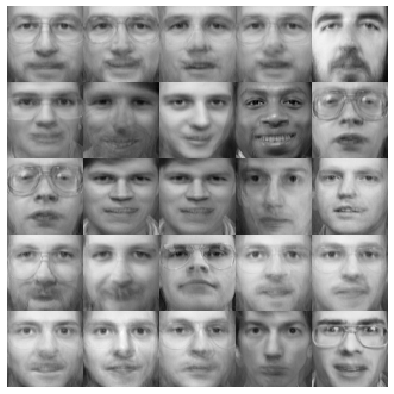

In [80]:
X_new_decomposed, _ = bgm.sample(25)
X_new = pca.inverse_transform(X_new_decomposed)

plot_faces(X_new, figsize=(7, 7))

The model generates some new faces that looks similar to the ones it was trained on, but some of them have new intereseting shapes. In cases where it failed, the faces are blurred. Maybe some extra filter could get rid of them.

Now let's have a look on some prepared anomalies and see whether the model can be used to find them.

In [81]:
def make_anomalies(X):
    size = 64
    result = np.empty_like(X)
    anomaly = np.empty_like(X[0])
    
    for i in range(25):
        rn = np.random.randint(3)
        if rn == 0:   # rotation
            anomaly = np.rot90(X[i].reshape((size, size)), k=np.random.randint(1, 4)).reshape((-1,))
        elif rn == 1: # flipping
            anomaly = np.flip(X[i].reshape((size, size)), axis=np.random.randint(2)).reshape((-1,))
        else:         # color change
            anomaly = X[i]
            if np.random.randint(2) == 0: # darkening
                anomaly *= np.random.rand()
            else:                         # lighting
                anomaly = 1.0 - (1.0 - anomaly)*np.random.rand()
        result[i] = anomaly
    return result

In [105]:
ok = data[np.random.choice(len(data), size=25, replace=False)]
anomalies = make_anomalies(ok)

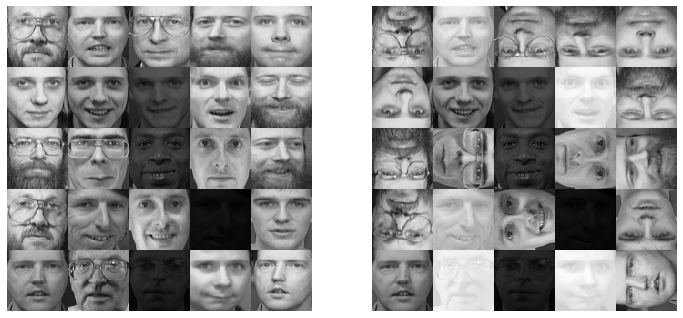

In [106]:
plt.figure(figsize=(12, 6))
plt.subplot(121); plot_faces(ok)
plt.subplot(122); plot_faces(anomalies)

In [107]:
ok_decomposed = pca.transform(ok)
anomalies_decomposed = pca.transform(anomalies)

In [108]:
ok_score = bgm.score_samples(ok_decomposed)
anomalies_score = bgm.score_samples(anomalies_decomposed)

print("Mean samples' score for ok set: {} with std: {}".format(ok_score.mean(), ok_score.std()))
print("Mean samples' score for anomalies set: {} with std: {}".format(anomalies_score.mean(), anomalies_score.std()))

Mean samples' score for ok set: -4235.233255079164 with std: 4428.037771164136
Mean samples' score for anomalies set: -20538.616010533577 with std: 11617.687624703194


It looks like the anomalies on average gets different scoring than good photos and the model detects them.

**The last thing we're going to do is to look at the reconstruction error of original images decomposed and then reconstructed and the same with generated faces.**

In [109]:
pca2 = PCA(n_components=0.99, random_state=42)
data_decomposed = pca2.fit_transform(data)
data_restored = pca2.inverse_transform(data_decomposed)

In [110]:
anomalies_decomposed = pca2.transform(anomalies)
anomalies_restored = pca2.inverse_transform(anomalies_decomposed)

In [111]:
from sklearn.metrics import mean_squared_error

print('Reconstruction error of the original images: {}'.format(mean_squared_error(data, data_restored)))
print('Reconstruction error of the anomalies images: {}'.format(mean_squared_error(anomalies, anomalies_restored)))

Reconstruction error of the original images: 0.00019257102394476533
Reconstruction error of the anomalies images: 0.0032691166270524263


The difference is significant.

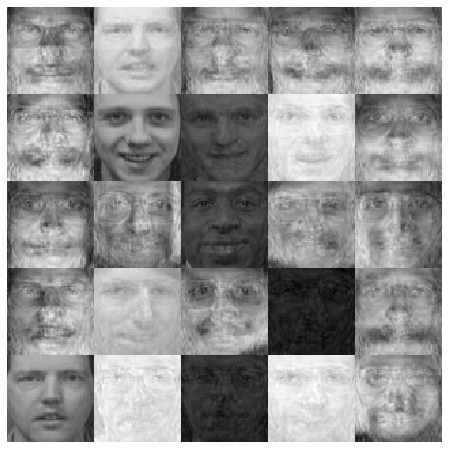

In [114]:
plot_faces(anomalies_restored, figsize=(8, 8))

So the reconstruction is aimed for restoring face elements that the algorithm noticed and when it has to do with anomalies it may produce such unnatural results.